## Fit and analyze ARHMMs
The next step of the BehaveNet pipeline is to model the low-dimensional representation of behavior with a simple class of nonlinear dynamical systems called autoregressive hidden Markov models (ARHMMs). An ARHMM models the sequence of continuous latents as a stochastic process that switches between a small number *K* of discrete states, each characterized by linear-Gaussian dynamics. These discrete state variables also exhibit temporal dependences through Markovian dynamics - the discrete state at time *t* may depend on its preceding value.

This model posits that the animal's behavior is composed of a small number (*K*) of discrete "behavioral syllables", such that many complex behaviors can be decomposed into sequences of these simpler syllables [[Wiltschko et al 2015](https://www.sciencedirect.com/science/article/pii/S0896627315010375), [Markowitz et al 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305129)]. This notebook will guide you through fitting ARHMMs with BehaveNet (using the `ssm` package as the backend) and analyzing basic properties of the fitted models.

<br>

### Contents
* [Fitting ARHMMs](#Fitting-ARHMMs)
* [Plot validation log probability as a function of discrete states](#Plot-validation-log-probability-as-a-function-of-discrete-states)
* [Visualize state segmentations for multiple trials](#Visualize-state-segmentations-for-multiple-trials)
* [Plot inferred and generated latents and states](#Plot-inferred-and-generated-latents-and-states)
* [Make real vs generated movies](#Make-real-vs-generated-movies)
* [Make syllable movies](#Make-syllable-movies)

In [1]:
import pickle
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.plotting.arhmm_utils import *

save_outputs = True  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4
model_class = 'arhmm'  # 'arhmm' | 'arhmm-labels'
lab_id = 'musall'
expt_id = 'vistrained'

## Fitting ARHMMs

Fitting a single ARHMM is very similar to the AE fitting procedure; first copy the example json files ``arhmm_compute.json``, ``arhmm_model.json``, and ``arhmm_training.json`` into your ``.behavenet`` directory, ``cd`` to the ``behavenet`` directory in the terminal, and run:

```console
$: python behavenet/fitting/arhmm_grid_search.py --data_config ~/.behavenet/musall_vistrained_params.json --model_config ~/.behavenet/arhmm_model.json --training_config ~/.behavenet/arhmm_training.json --compute_config ~/.behavenet/arhmm_compute.json
```

[Back to contents](#Contents)

## Plot validation log probability as a function of discrete states
The number of discrete ARHMM states *K* is an important hyperparameter of the model. Though there is no one best way to choose *K*, a helpful diagnostic is to look at the log probability of the trained ARHMM on held-out validation data as a function of *K*.

[Back to contents](#Contents)

In [2]:
from behavenet.fitting.utils import get_subdirs

# define which arhmm states to plot (must already be fit)
n_arhmm_states = [2, 4, 8, 12]

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'state_number_search',
    'model_class': model_class,
    'model_type': None,
    'noise_type': 'gaussian',
    'n_arhmm_lags': 1,
    'kappa': 0,
    'ae_experiment_name': 'ae-example',
    'n_ae_latents': 9,
}
get_lab_example(hparams, lab_id, expt_id)

metrics_df = []
for n_states in n_arhmm_states:
    hparams['n_arhmm_states'] = n_states
    hparams['session_dir'], _ = get_session_dir(hparams)
    expt_dir = get_expt_dir(hparams)
    # gather all versions
    try:
        versions = get_subdirs(expt_dir)
    except Exception:
        print('No models in %s; skipping' % expt_dir)
        continue
    # load csv files with model metrics (saved out from test tube)
    for i, version in enumerate(versions):
        # read metrics csv file
        model_dir = os.path.join(expt_dir, version)
        try:
            metrics = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
        except:
            continue
        with open(os.path.join(model_dir, 'meta_tags.pkl'), 'rb') as f:
            hp_new = pickle.load(f)
        if not hp_new['training_completed']:
            continue
        for i, row in metrics.iterrows():
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['test_loss'],
                    'n_states': n_states}, index=[0]))
metrics_df = pd.concat(metrics_df)

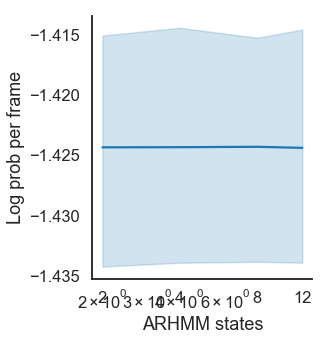

In [3]:
# plot data
sns.set_style('white')
sns.set_context('talk')

splt = sns.relplot(x='n_states', y='loss', hue=None, kind='line', data=metrics_df)
splt.ax.set_xlabel('ARHMM states')
splt.ax.set_xscale('log')
splt.ax.set_xticks(n_arhmm_states)
splt.ax.set_xticklabels(n_arhmm_states)
splt.ax.set_ylabel('Log prob per frame')

if save_outputs:
    filename = os.path.join(get_user_dir('fig'), hparams['model_class'], 'll_vs_states')
    make_dir_if_not_exists(filename)
    plt.savefig(filename + '.' + format, dpi=300, format=format)

plt.show()

## Visualize state segmentations for multiple trials
Another useful visualization is to plot ARHMM state segmentations over multiple trials, where each time point is colored based on the discrete state assigned by the ARHMM.

[Back to contents](#Contents)

In [4]:
def plot_segmentations_by_trial(
        states, xtick_locs=None, xticklabel_offset=0, frame_rate=None, save_file=None, 
        title=None, cmap='tab20b'):

    from matplotlib.lines import Line2D

    n_trials = len(states)

    fig = plt.figure(figsize=(10, n_trials / 4))
    gs_bottom_left = plt.GridSpec(n_trials, 1, top=0.85, right=1)
    for i_trial in range(n_trials):

        axes = plt.subplot(gs_bottom_left[i_trial, 0])
        axes.imshow(
            states[i_trial][None, :], aspect='auto',
            extent=(0, len(states[i_trial]), 0, 1), cmap=cmap, alpha=0.8)
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_frame_on(False)

    if xtick_locs is not None and frame_rate is not None:
        axes.set_xticks(xtick_locs)
        axes.set_xticklabels(
            ((xticklabel_offset + np.asarray(xtick_locs)) / frame_rate).astype('int'))
        axes.set_xlabel('Time (s)')
    else:
        axes.set_xlabel('Time (bins)')
    axes = plt.subplot(gs_bottom_left[int(np.floor(n_trials / 2)), 0])
    axes.set_ylabel('Trials')

    plt.suptitle(title)
    plt.tight_layout()

    if save_file is not None:
        make_dir_if_not_exists(save_file)
        fig.savefig(save_file, transparent=True, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    return fig

In [5]:
from behavenet.plotting.arhmm_utils import get_model_latents_states

# user params
get_best_version = True  # False when looking at multiple models w/in a tt expt
dtype = 'test'  # data type to draw trials from: 'train' | 'val' | 'test'
sess_idx = 0  # when using a multisession, this determines which session is used
max_frames = 200

# define which arhmm states to plot (must already be fit)
n_arhmm_states = [2, 4]

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'state_number_search',
    'model_class': model_class,
    'model_type': None,
    'noise_type': 'gaussian',
    'n_arhmm_lags': 1,
    'kappa': 0,
    'ae_experiment_name': 'ae-example',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'n_ae_latents': 9,
}
get_lab_example(hparams, lab_id, expt_id)

xtick_locs = [0, 30, 60, 90, 120, 150, 180]
frame_rate = 30
n_trials = 20
           
# add additional params to identify model
hparams['device'] = 'cpu'
hparams['as_numpy'] = True
hparams['batch_load'] = True
hparams['rng_seed_model'] = 0
hparams['rng_seed_data'] = 0
hparams['trial_splits'] = '8;1;1;0'
hparams['train_frac'] = 1.0

for n_states in n_arhmm_states:
        
    hparams['n_arhmm_states'] = n_states

    if hparams['model_class'] == 'arhmm':           
        model_name = str(
            'multitrial_segmentation_D=%02i_K=%02i' % (
            hparams['n_ae_latents'], hparams['n_arhmm_states']))
    elif hparams['model_class'] == 'arhmm-labels':
        model_name = str('multitrial_segmentation_K=%02i' % hparams['n_arhmm_states'])

    mdict = get_model_latents_states(hparams, '', dtype=dtype, dtypes=[dtype])
    
    # choose which trials to plot
    np.random.seed(0)
    trial_vec = np.random.choice(
        np.arange(0, len(mdict['trial_idxs'][dtype])), size=(n_trials,), 
        replace=False)

    # collect states
    for i, j in enumerate(trial_vec):
        x = mdict['latents'][dtype][j][:max_frames]
        states_tmp = mdict['model'].most_likely_states(x)
        n_frames = len(states_tmp)
        mdict['states'][dtype][j][:n_frames] = states_tmp

    if save_outputs:
        save_file = os.path.join(
            get_user_dir('fig'), hparams['model_class'], model_name + '.' + format)
    else:
        save_file = None

    fig = plot_segmentations_by_trial(
        [mdict['states'][dtype][t] for t in trial_vec], xtick_locs,  
        0, frame_rate, save_file=save_file, title=model_name)

using data from following sessions:
/home/mattw/results/behavenet_tmp/cortexlab/ephys/KS005/2019-08-30-001_dlc-test
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
cortexlab_ephys_KS005_2019-08-30-001_dlc-test
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5')])



/home/mattw/anaconda3/envs/behavenet/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/mattw/anaconda3/envs/behavenet/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


using data from following sessions:
/home/mattw/results/behavenet_tmp/cortexlab/ephys/KS005/2019-08-30-001_dlc-test
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
cortexlab_ephys_KS005_2019-08-30-001_dlc-test
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5')])



## Plot inferred and generated latents and states
The ARHMM is a fully probabilistic model, which means that we can generate synthetic data from it. For example, we can sample a path of the Markov chain, and use these discrete states to generate observations (CAE latents) from the learned linear-Gaussian dynamics.

Comparing inferred CAE latents and ARHMM states with those generated from the model can be a useful way to understand if the ARHMM is indeed a good generative model of the data.

There are two ways to generate data from the ARHMM:
* **conditional sampling**: Generated data is conditioned on the most likely discrete states inferred from a batch of data. This tests how well the learned linear-Gaussian dynamics fit the data.
* **unconditional sampling**: A discrete state sequence is first sampled from the learned Markov chain, and then the generated data is conditioned on this states sequence. This additionally tests how well the Markov transition matrix has learned the statistical structure of switching in the data.

[Back to contents](#Contents)

using data from following sessions:
/home/mattw/results/behavenet_tmp/cortexlab/ephys/KS005/2019-08-30-001_dlc-test
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
cortexlab_ephys_KS005_2019-08-30-001_dlc-test
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5')])

using data from following sessions:
/home/mattw/results/behavenet_tmp/cortexlab/ephys/KS005/2019-08-30-001_dlc-test
constructing data generator...done
Generator contains 1 SingleSessionDataset objects:
cortexlab_ephys_KS005_2019-08-30-001_dlc-test
    signals: ['labels']
    transforms: OrderedDict([('labels', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5')])



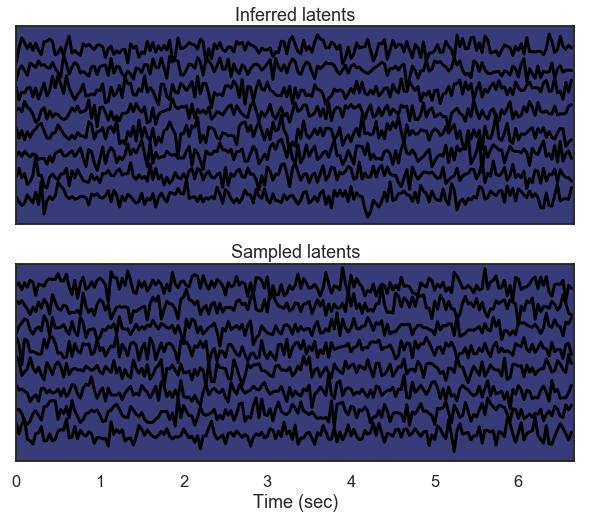

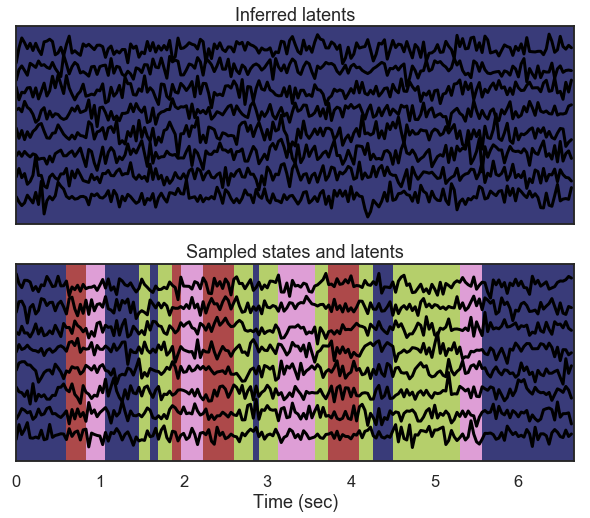

In [6]:
from behavenet.plotting.arhmm_utils import get_model_latents_states
from behavenet.plotting.arhmm_utils import plot_states_overlaid_with_latents

# user params
sess_idx = 0  # when using a multisession, this determines which session is used
version = ''  # test-tube version; 'best' finds the version with the lowest mse

xtick_locs = [0, 30, 60, 90, 120, 150, 180]
frame_rate = 30
max_frames = 200

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'state_number_search',
    'model_class': model_class,
    'model_type': None,
    'n_arhmm_states': 4,
    'noise_type': 'gaussian',
    'n_arhmm_lags': 1,
    'kappa': 0,
    'ae_experiment_name': 'ae-example',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'n_ae_latents': 9,
    'rng_seed_data': 0,
    'rng_seed_model': 0,
    'train_frac': 1.0,
    'trial_splits': '8;1;1;0'
}
get_lab_example(hparams, lab_id, expt_id)

np.random.seed(101)

# cond_sampling: True to condition samples on inferred discrete states of real data
for cond_sampling in [True, False]:
    
    save_str = 'conditional' if cond_sampling else 'unconditional'
    if hparams['model_class'] == 'arhmm':           
        file_name = str('infer_vs_sample_%s_D=%02i_K=%02i' % (
            save_str, hparams['n_ae_latents'], hparams['n_arhmm_states']))
    elif hparams['model_class'] == 'arhmm-labels':
        file_name = str('infer_vs_sample_%s_K=%02i' % (
            save_str, hparams['n_arhmm_states']))
    save_file = os.path.join(get_user_dir('fig'), hparams['model_class'], file_name)
    
    fig = real_vs_sampled_wrapper(
        'both', hparams, save_file, 0, xtick_locs=xtick_locs, max_frames=max_frames,
        frame_rate=frame_rate, frame_rate_beh=frame_rate, conditional=cond_sampling)

## Make syllable movies
If many behaviors can indeed be decomposed into a sequence of simpler actions we might hope these are represented by the ARHMM discrete states. A useful, *qualitative* way to gauge interpretability of the ARHMM discrete states is to watch clips of the original behavioral video during all times when the animal is in, say, state *k*.

The following cell will take all data of a certain type (training, validation, or testing), and for each discrete state extract all time windows when that state is in the most likely state sequence. The behavioral video for these time windows (as well as a small number of buffer frames before state onset) is then animated, with different time windows separated by a few blank frames.

This process is repeated for each discrete state, and all discrete states are animated simultaneously, each in their own subplot (though movies can be made one state at a time - see `make_syllable_movies_wrapper()` documentation).

[Back to contents](#Contents)

producing syllable videos for arhmm 0
using data from following sessions:
/home/mattw/results/behavenet_tmp/cortexlab/ephys/KS005/2019-08-30-001_dlc-test
constructing data generator...Warning: loading all images!
done
Generator contains 1 SingleSessionDataset objects:
cortexlab_ephys_KS005_2019-08-30-001_dlc-test
    signals: ['labels', 'images']
    transforms: OrderedDict([('labels', None), ('images', None)])
    paths: OrderedDict([('labels', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5'), ('images', '/media/mattw/data/ibl-bn/cortexlab/ephys/KS005/2019-08-30-001_dlc-test/data.hdf5')])

processing syllable 1/4
processing syllable 2/4
processing syllable 3/4
processing syllable 4/4
creating animation...done
saving video to /home/mattw/results/behavenet_tmp/figs/arhmm-labels/syllable-movies_K=04.mp4...done


<Figure size 432x288 with 0 Axes>

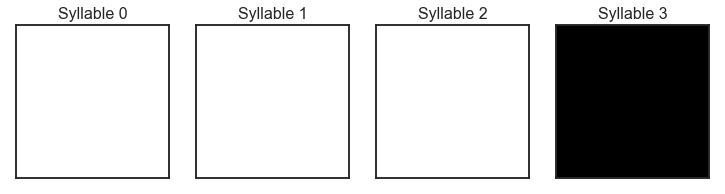

In [7]:
from behavenet.plotting.arhmm_utils import make_syllable_movies_wrapper

# user params
dtype = 'train'  # data type to draw trials from: 'train' | 'val' | 'test'
sess_idx = 0  # when using a multisession, this determines which session is used

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'state_number_search',
    'model_class': model_class,
    'model_type': None,
    'n_arhmm_states': 4,
    'noise_type': 'gaussian',
    'n_arhmm_lags': 1,
    'kappa': 0,
    'ae_experiment_name': 'ae-example',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'n_ae_latents': 9,
    'rng_seed_data': 0,
    'rng_seed_model': 0,
    'train_frac': 1.0,
    'trial_splits': '8;1;1;0'
}

# programmatically fill out other hparams options
get_lab_example(hparams, lab_id, expt_id)

if hparams['model_class'] == 'arhmm':           
    file_name = str('syllable-movies_D=%02i_K=%02i' % 
                    (hparams['n_ae_latents'], hparams['n_arhmm_states']))
elif hparams['model_class'] == 'arhmm-labels':
    file_name = str('syllable-movies_K=%02i' % hparams['n_arhmm_states'])
save_file = os.path.join(get_user_dir('fig'), hparams['model_class'], file_name)
    
make_syllable_movies_wrapper(hparams, save_file, sess_idx=sess_idx, n_rows=1, dtype=dtype)